In [5]:
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES
from classes.MPNN import MPNN
from functions.compute_loss import compute_loss
from functions.evaluations import *
from functions.evaluations import evaluate_model
from functions.train import train_MPNN_model

# Load the data and couple the SMILES to the yields and remove nan's

In [6]:
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged = data_loader(yields_path, smiles_path)


#print("Merged DataFrame:")
#print(df_merged)


Convert the SMILES to Graphs

## Zet de SMILES om naar graphs

In [7]:
from rdkit import Chem

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        mol_graph = MolecularGraphFromSMILES(row['smiles_raw'])

        borylation_index = row['borylation_site']

        graph = mol_graph.to_pyg_data()
        graphs.append(graph)

    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}")
        print(f"  - borylation_site: {row['borylation_site']}")
        mol = Chem.MolFromSmiles(row['smiles_raw'])
        if mol:
            print(f"  - aantal atomen in RDKit mol: {mol.GetNumAtoms()}")
        else:
            print("  - RDKit kon mol niet parsen!")
        print(f"  - foutmelding: {e}")


# Eerste splitsing: 85% train+val, 15% test
train_val_graphs, test_graphs = train_test_split(
    graphs, test_size=0.15, random_state=42
)

# Tweede splitsing: 70/15 = 70/85, 0.8235 voor train
train_graphs, val_graphs = train_test_split(
    train_val_graphs, test_size=0.1765, random_state=42
)



Converting SMILES to graphs: 100%|██████████| 83/83 [00:00<00:00, 469.26it/s]


## Zet de graphs in een dataloader zodat het de GNN in kan

[Epoch 1] Train loss: 0.8067 | Site: 1.5228, Yield: 0.0905
[Epoch 2] Train loss: 0.7090 | Site: 1.4092, Yield: 0.0089
[Epoch 3] Train loss: 0.6474 | Site: 1.2869, Yield: 0.0079
[Epoch 4] Train loss: 0.6089 | Site: 1.2143, Yield: 0.0035
[Epoch 5] Train loss: 0.5610 | Site: 1.1190, Yield: 0.0031
[Epoch 6] Train loss: 0.5236 | Site: 1.0413, Yield: 0.0058
[Epoch 7] Train loss: 0.4675 | Site: 0.9335, Yield: 0.0015
[Epoch 8] Train loss: 0.4186 | Site: 0.8362, Yield: 0.0010
[Epoch 9] Train loss: 0.3727 | Site: 0.7446, Yield: 0.0009
[Epoch 10] Train loss: 0.3273 | Site: 0.6542, Yield: 0.0005
[Epoch 11] Train loss: 0.2912 | Site: 0.5815, Yield: 0.0009
[Epoch 12] Train loss: 0.2812 | Site: 0.5621, Yield: 0.0002
[Epoch 13] Train loss: 0.2792 | Site: 0.5580, Yield: 0.0005
[Epoch 14] Train loss: 0.3006 | Site: 0.6010, Yield: 0.0002
[Epoch 15] Train loss: 0.2334 | Site: 0.4658, Yield: 0.0009
[Epoch 16] Train loss: 0.2105 | Site: 0.4205, Yield: 0.0004
[Epoch 17] Train loss: 0.1922 | Site: 0.3837, Yie

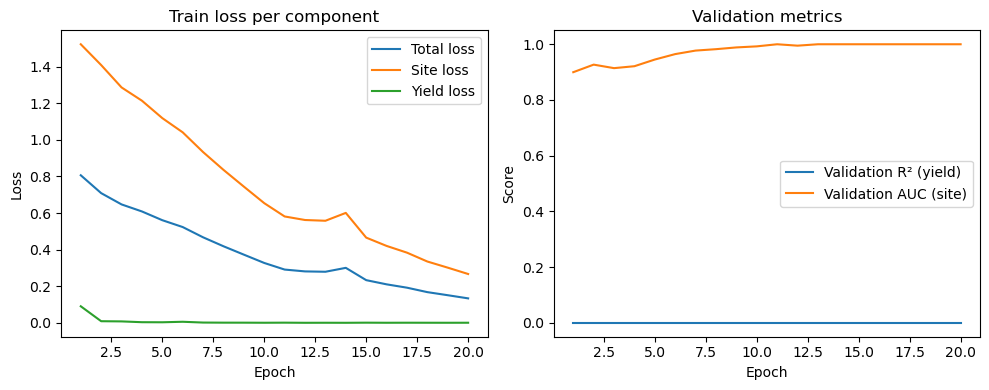

 Testresultaten:

 Borylation site prediction:
   - Accuracy      : 0.943
   - Precision     : 0.650
   - ROC AUC       : 0.999
   - Top-1 Accuracy: 1.000
   - Top-3 Accuracy: 1.000

 Yield prediction:
   - MSE           : 0.000
   - MAE           : 0.016
   - R²            : 0.000
Gemiddelde voorspelde yield: 0.31594685
Gemiddelde echte yield: 0.3303587


In [9]:
import torch
from torch_geometric.loader import DataLoader

# Instellingen
batch_size = 32
num_epochs = 20
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture MPNN
node_in_feats=train_graphs[0].x.shape[1]                # Aantal input features per node
edge_in_feats=train_graphs[0].edge_attr.shape[1]        # Aantal input features per edge
hidden_feats=64                                         # Aantal verborgen features
num_step_message_passing=3                              # Aantal stappen voor message passing
num_step_set2set=3                                      # Aantal stappen voor Set2Set
num_layer_set2set=1                                     # Aantal lagen voor Set2Set
readout_feats=1024                                      # Aantal features voor readout
activation='leaky_relu'                                 # Activatiefunctie
dropout=0.2                                             # Dropout percentage

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

# Initialiseer model
model = MPNN(
    node_in_feats=node_in_feats,
    edge_in_feats=edge_in_feats,
    hidden_feats=hidden_feats,
    num_step_message_passing=num_step_message_passing,
    num_step_set2set=num_step_set2set,
    num_layer_set2set=num_layer_set2set,
    readout_feats=readout_feats,
    activation=activation,
    dropout=dropout
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop met validatie

train_total_loss_list = []
train_site_loss_list = []
train_yield_loss_list = []

val_r2_list = []
val_auc_list = []


for epoch in range(num_epochs):
    train_losses = train_MPNN_model(model, train_loader, optimizer, device)
    val_metrics, val_y_true, val_y_pred = evaluate_model(model, val_loader, device)

    print(f"[Epoch {epoch+1}] Train loss: {train_losses['total']:.4f} | "
        f"Site: {train_losses['site']:.4f}, "
        f"Yield: {train_losses['yield']:.4f}")
    train_total_loss_list.append(train_losses['total'])
    train_site_loss_list.append(train_losses['site'])
    train_yield_loss_list.append(train_losses['yield'])

    val_r2_list.append(float(val_metrics['yield_R2']))
    val_auc_list.append(val_metrics['site_AUC'])

# Evaluatie op testset na training
print("Evaluatie op testset na training:")
test_metrics, y_true, y_pred = evaluate_model(model, test_loader, device)
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_total_loss_list, label="Total loss")
plt.plot(epochs, train_site_loss_list, label="Site loss")
plt.plot(epochs, train_yield_loss_list, label="Yield loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train loss per component")
plt.legend()

# Validation metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2_list, label="Validation R² (yield)")
plt.plot(epochs, val_auc_list, label="Validation AUC (site)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation metrics")
plt.legend()

plt.tight_layout()
plt.show()


# Bereken Top-k accuracies (k=1 en k=3)
all_site_logits = []
all_site_masks = []
all_batches = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_borylation, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        all_site_logits.append(torch.sigmoid(p_borylation))  # sigmoid omdat topk op probs werkt
        all_site_masks.append(batch.borylation_mask)
        all_batches.append(batch.batch)

p_borylation = torch.cat(all_site_logits)
borylation_mask = torch.cat(all_site_masks)
batch_tensor = torch.cat(all_batches)

acc_top1 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=1)
acc_top3 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=3)

# Print resultaten
print(" Testresultaten:")
print(f"\n Borylation site prediction:")
print(f"   - Accuracy      : {test_metrics['site_Accuracy']:.3f}")
print(f"   - Precision     : {test_metrics['site_Precision']:.3f}")
print(f"   - ROC AUC       : {test_metrics['site_AUC']:.3f}")
print(f"   - Top-1 Accuracy: {acc_top1:.3f}")
print(f"   - Top-3 Accuracy: {acc_top3:.3f}")

print(f"\n Yield prediction:")
print(f"   - MSE           : {test_metrics['yield_MSE']:.3f}")
print(f"   - MAE           : {test_metrics['yield_MAE']:.3f}")
print(f"   - R²            : {test_metrics['yield_R2']:.3f}")

print("Gemiddelde voorspelde yield:", y_pred.mean())
print("Gemiddelde echte yield:", y_true.mean())


